In [1]:
import numpy as np
from aicsimageio import AICSImage
import torch as ch
from tqdm import tqdm
from os import path

from confocalQuant.segmentation import load_3D, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference,  sigmoid, gamma_correct_image, get_czi_files
from confocalQuant.quantification import get_all_expectations
from confocalQuant.image import save_mean_proj

import argparse
from distutils.util import strtobool
import os

import ast
import pandas as pd

from cellpose import models

import matplotlib.pyplot as plt

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from scipy.stats import ttest_ind
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aicsimageio import AICSImage
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels
import os 

import numba as nb
@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E_uniform, E_nonuniform):
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        E_uniform[M] = np.mean(temp_vals)
        E_nonuniform[M] = np.dot(temp_vals, temp_probs/np.sum(temp_probs))
        
def extract_sbatch_parameters(file_path):
    parameters = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            # Ignore comments
            if line.startswith("#"):
                continue

            # Extract key-value pairs or parameters in list form
            parts = line.split()
            if len(parts) >= 2:
                key, *values = parts
                if '\\' in values:
                    # Handle parameters in the form of "--key value1 value2 \"
                    values = values[:values.index('\\')]
                parameters[key] = values
            elif len(parts) == 1:
                # Handle parameters in list form
                parameters.setdefault('list_parameters', []).extend(parts)

    return parameters

def return_results(path_to_sbatch_file, prefix):
    # get data and params
    params = extract_sbatch_parameters(path_to_sbatch_file)
    folder = params['--folder'][0][1:-1]
    NZi = int(params['--NZi'][0])
    xi_per_job = int(params['--xi_per_job'][0])
    yi_per_job = int(params['--yi_per_job'][0])
    cells_per_job = int(params['--cells_per_job'][0])
    Ncells = int(params['--Ncells'][0])
    Njobs = int(params['--Njobs'][0])
    channels = [int(x) for x in params['--channels']]
    mode = 'r'
    zi_per_job = int(params['--zi_per_job'][0])

    all_mat = np.lib.format.open_memmap(path.join(prefix + folder, 'mat.npy'), shape=(NZi, xi_per_job, yi_per_job, len(channels)), dtype=float, mode=mode)
    all_masks = np.lib.format.open_memmap(path.join(prefix + folder, 'masks.npy'), shape=(NZi, xi_per_job, yi_per_job), dtype='uint16', mode=mode)
    Nzi_per_job = np.lib.format.open_memmap(path.join(prefix + folder, 'Nzi_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)
    probs = np.lib.format.open_memmap(path.join(prefix + folder, 'probs.npy'), shape=(Njobs,1), dtype=float, mode=mode)
    
    return all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs

In [3]:
parent = './data/neuronbatch11082023_mitohealth//'

In [4]:
files = get_czi_files(parent)
meta = pd.read_csv(parent + 'temp.csv')
dictionary = dict(zip(meta['filename'], meta['line']))
dictionary2 = dict(zip(meta['filename'], meta['treatment']))
lines = [dictionary[x.split('.')[0]] for x in files]
treat = [dictionary2[x.split('.')[0]] for x in files]

In [5]:
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs = return_results('./outs/neuronbatch11082023_mitohealth_out/run_jobs_110823_mito.sbatch', '')

In [6]:
channels = [0,1,2]
channel_names = ['DAPI', 'NeuN', 'Mitohealth']
res = []

for ID in tqdm(range(len(files))):
    start = ID*zi_per_job
    end = start + Nzi_per_job[ID][0]
    
    probs_sele = probs[start:end].ravel()
    masks_sele = all_masks[start:end].ravel()
    out_float_sele = all_mat[start:end]
    
    M_unique = np.unique(masks_sele)
    NM = len(M_unique)
    
    outputs = np.empty((NM, len(channels)))
    
    E_uniform = np.empty(NM)
    E_nonuniform = np.empty(NM)

    for C in channels:
        vals_sele = out_float_sele[:,:,:,C].ravel()
        get_expectations(NM, masks_sele, probs_sele, vals_sele, E_uniform, E_nonuniform)
        outputs[:,C] = E_nonuniform
        
    df = pd.DataFrame(outputs[1:])
    df.columns = ['channel_' + str(i) for i in channel_names]
    df['ID'] = ID
    df['file'] = files[ID]
    df['line'] = lines[ID]
    df['treatment'] = treat[ID]
    
    res.append(df)

  0%|          | 0/72 [00:00<?, ?it/s]/home/gridsan/djuna/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 72/72 [07:39<00:00,  6.39s/it]


In [7]:
df = pd.concat(res)

In [8]:
df['well'] = [x.split('-')[0] for x in df['file']]

In [9]:
df.head()

,channel_DAPI,channel_NeuN,channel_Mitohealth,ID,file,line,treatment,well
0,0.080194,0.254811,0.043982,0,B03-1.czi,E3,vehicle,B03
1,0.053198,0.371078,0.038321,0,B03-1.czi,E3,vehicle,B03
2,0.083390,0.216601,0.042992,0,B03-1.czi,E3,vehicle,B03
3,0.060753,0.153305,0.076045,0,B03-1.czi,E3,vehicle,B03
4,0.089477,0.163853,0.065523,0,B03-1.czi,E3,vehicle,B03


In [10]:
df.index = range(df.shape[0])

In [12]:
np.unique(df['line'], return_counts=True)

(array(['E3', 'G2', 'Y622'], dtype=object), array([1361, 2315, 3893]))

In [14]:
np.unique(lines, return_counts=True)

(array(['E3', 'G2', 'Y622'], dtype='<U4'), array([24, 24, 24]))

In [25]:
pd.DataFrame(np.unique(df[df['line']=='E3']['well'], return_counts=True)).T

,0,1
0,B03,143
1,B04,76
2,B05,47
3,B06,42
4,B07,37
5,B08,42
6,B09,65
7,B10,88
8,C02,63
9,C03,111


In [28]:
pd.DataFrame(np.unique(df[df['line']=='G2']['treatment'], return_counts=True)).T

,0,1
0,CDP-choline,429
1,DGAT1/2i,524
2,GW501516,357
3,rosiglitazone,351
4,sn-glycero-3-phosphocholine,374
5,vehicle,280


In [27]:
pd.DataFrame(np.unique(df[df['line']=='Y622']['well'], return_counts=True)).T

,0,1
0,D02,218
1,D03,174
2,D04,168
3,D05,126
4,D06,210
5,D07,141
6,D08,197
7,D09,187
8,D10,329
9,D11,391


In [16]:
np.unique(df['well'], return_counts=True)

(array(['B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'C02',
        'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11',
        'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10',
        'D11', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09',
        'E10', 'E11', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08',
        'F09', 'F10', 'F11', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07',
        'G08', 'G09', 'G10', 'G11'], dtype=object),
 array([143,  76,  47,  42,  37,  42,  65,  88,  63, 111,  47,  58,  99,
         79,  28,  62, 102, 172, 218, 174, 168, 126, 210, 141, 197, 187,
        329, 391, 150, 113, 132, 122, 183, 197, 158, 100, 297, 300,  70,
         44,  92, 122,  84,  45,  40,  96, 154, 303,  98,  68, 142,  73,
        139, 106,  71, 144, 203, 221]))

In [ ]:
np.unique(lines, return_counts=True)

#### MITO

(0.0, 0.4)

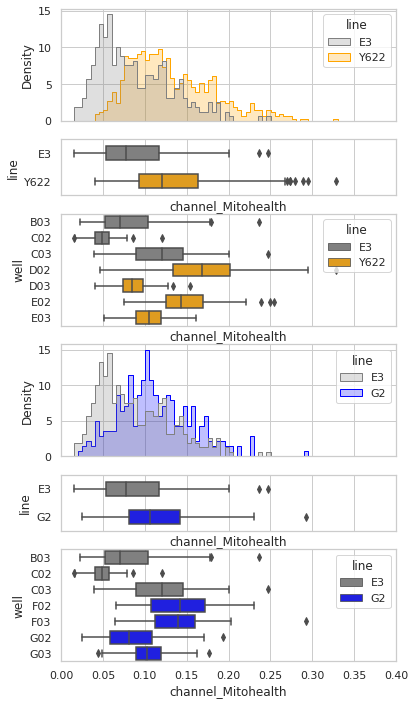

In [26]:
df_temp = df[df['treatment']=='vehicle']

#set1_colors = sns.color_palette('husl')
#colors = dict(zip(np.unique(df['line']), set1_colors[:6]))

colors = dict(zip(np.unique(df['line']), ['grey', 'blue', 'orange']))

sns.set(rc={'figure.figsize':(6,12)})
sns.set_style("whitegrid")

f, ax = plt.subplots(6, sharex=True, gridspec_kw={"height_ratios": (1,.5,1,1,.5,1)})


index = df_temp['line']!='G2'
sns.histplot(data=df_temp[index], x='channel_Mitohealth', ax=ax[0], hue='line', binwidth=0.005, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='line',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='well',orient="h", ax=ax[2], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)

index = df_temp['line']!='Y622'
sns.histplot(data=df_temp[index], x='channel_Mitohealth', ax=ax[3], hue='line', binwidth=0.005, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='line',orient="h", ax=ax[4], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='well',orient="h", ax=ax[5], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)


plt.xlim(0,0.4)

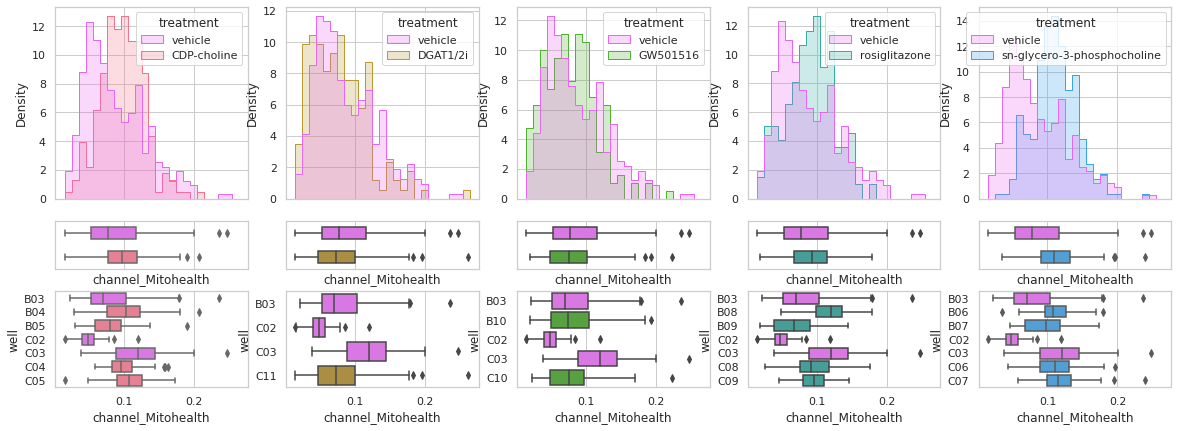

In [21]:
df_temp = df[df['line']=='E3']

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(df['treatment']), set1_colors[:6]))

sns.set(rc={'figure.figsize':(20,7)})
sns.set_style("whitegrid")

f, ax = plt.subplots(3,5, sharex=True, gridspec_kw={"height_ratios": (1,.25,.5)})


for i,t in enumerate(np.unique(df['treatment'])[:-1]):
    index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
    sns.histplot(data=df_temp[index], x='channel_Mitohealth', ax=ax[0,i], hue='treatment', binwidth=0.01, element="step", common_norm=False, stat='density', palette = colors)
    sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='treatment',orient="h", ax=ax[1,i], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    sns.boxplot(data=df_temp[index], x='channel_Mitohealth', y='well',orient="h", ax=ax[2,i], width=.8, dodge=False, hue = 'treatment', palette = colors)#, order =(order))#, palette = colors)
    ax[2,i].get_legend().remove()
    ax[1,i].axes.get_yaxis().set_visible(False)


#plt.xlim(0,0.4)

### MITO

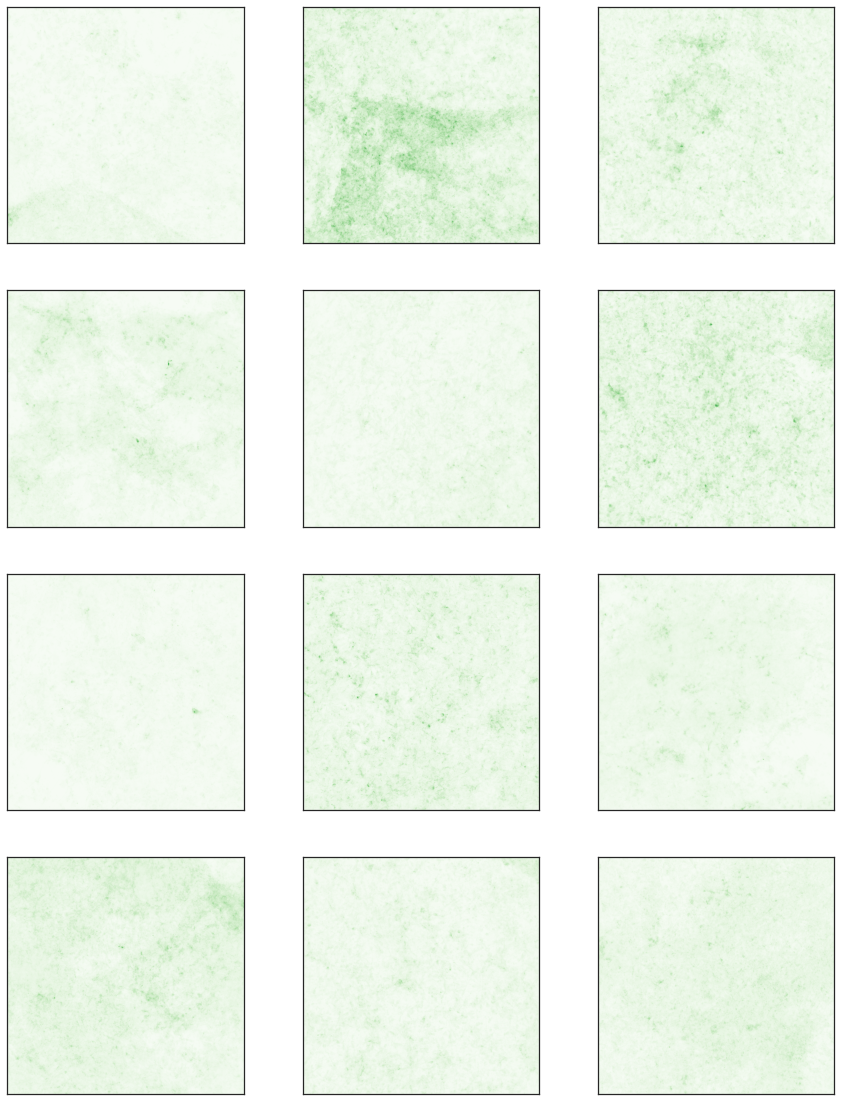

In [31]:
# example images, 1 Z
sns.set(style="white", rc={"axes.grid": False})
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
C = 2
cellline = ['E3', 'Y622', 'G2']
for x, c in enumerate(cellline):
    sele = np.argwhere(np.array([i=='vehicle' for i in treat]) & np.array([i==c for i in lines])).reshape(-1)
    for n,i in enumerate(sele):
        img = AICSImage('./data/neuronbatch11082023_mitohealth//'+files[i])
        out = load_3D(img, [0,1,2])
        out_float = int_to_float(out)
        axes[n,x].imshow(np.mean(out_float[:,:,:,C], axis=0), vmin=0, vmax=.3,cmap='Greens')
        axes[n,x].axes.get_xaxis().set_visible(False)
        axes[n,x].axes.get_yaxis().set_visible(False)


### below is scrap

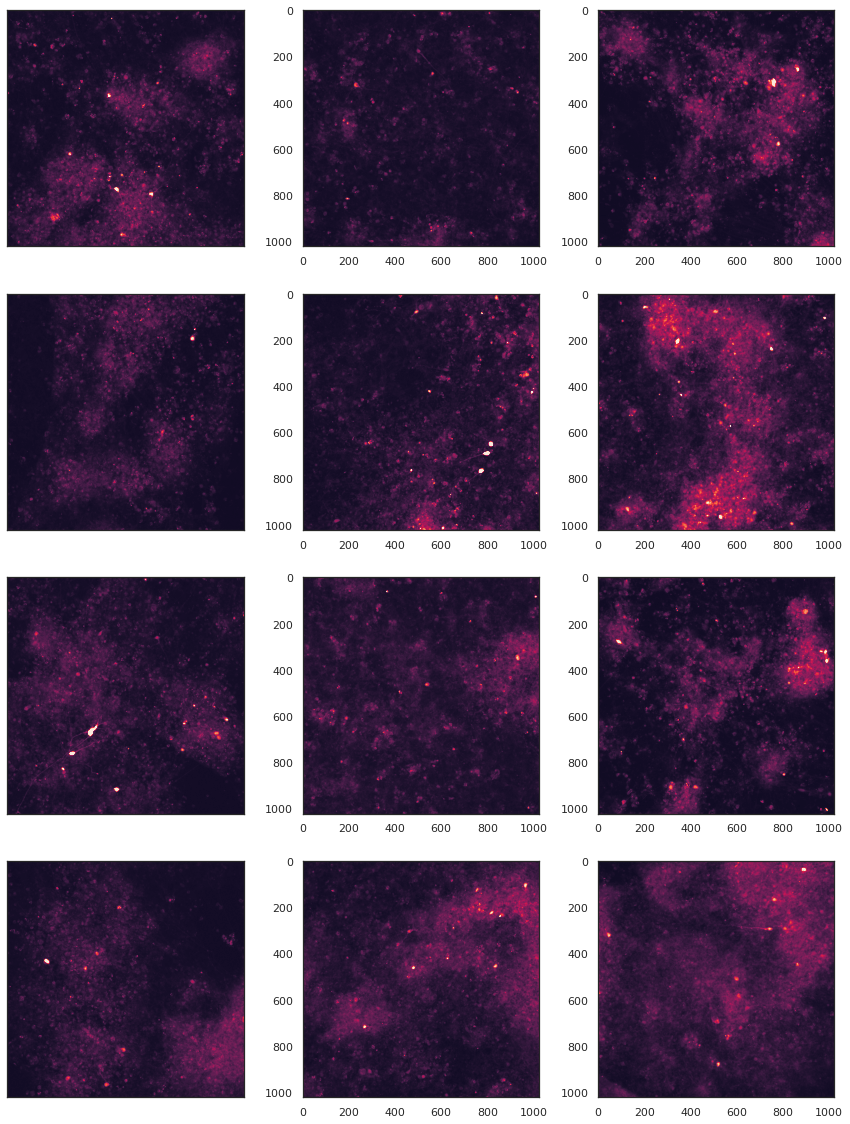

In [607]:


sele = np.argwhere(np.array([i=='vehicle' for i in treat]) & np.array([i=='Y622' for i in lines])).reshape(-1)

for n,i in enumerate(sele):
    img = AICSImage('./data/neuronbatch11082023_cellrox_bodipy/'+files[i])
    out = load_3D(img, [0,2,1,3])
    out_float = int_to_float(out)
    axes[n,1].imshow(np.mean(out_float[:,:,:,C], axis=0), vmin=0, vmax=.1)#,cmap='Greens')
    axes[n,0].imshow(np.mean(out_float[:,:,:,C], axis=0), vmin=0, vmax=.1)#,cmap='Greens')
    axes[n,0].axes.get_xaxis().set_visible(False)
    axes[n,0].axes.get_yaxis().set_visible(False)


    
sele = np.argwhere(np.array([i=='vehicle' for i in treat]) & np.array([i=='G2' for i in lines])).reshape(-1)

for n,i in enumerate(sele):
    img = AICSImage('./data/neuronbatch11082023_cellrox_bodipy/'+files[i])
    out = load_3D(img, [0,2,1,3])
    out_float = int_to_float(out)
    axes[n,2].imshow(np.mean(out_float[:,:,:,C], axis=0), vmin=0, vmax=.1)#,cmap='Greens')
    axes[n,2].imshow(np.mean(out_float[:,:,:,C], axis=0), vmin=0, vmax=.1)#,cmap='Greens')
    axes[n,2].axes.get_xaxis().set_visible(False)
    axes[n,2].axes.get_yaxis().set_visible(False)





In [605]:
axes[1,1].gca().set_xticks([])  # Hide x ticks and labels


AttributeError: 'Axes' object has no attribute 'gca'

(0.0, 0.03)

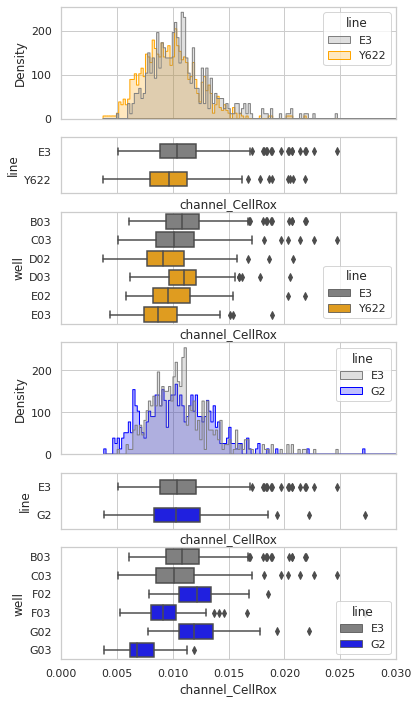

In [579]:
df_temp = df[df['treatment']=='vehicle']

#set1_colors = sns.color_palette('husl')
#colors = dict(zip(np.unique(df['line']), set1_colors[:6]))

colors = dict(zip(np.unique(df['line']), ['grey', 'blue', 'orange']))

sns.set(rc={'figure.figsize':(6,12)})
sns.set_style("whitegrid")

f, ax = plt.subplots(6, sharex=True, gridspec_kw={"height_ratios": (1,.5,1,1,.5,1)})


index = df_temp['line']!='G2'
sns.histplot(data=df_temp[index], x='channel_CellRox', ax=ax[0], hue='line', binwidth=0.0002, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_CellRox', y='line',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
sns.boxplot(data=df_temp[index], x='channel_CellRox', y='well',orient="h", ax=ax[2], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)

index = df_temp['line']!='Y622'
sns.histplot(data=df_temp[index], x='channel_CellRox', ax=ax[3], hue='line', binwidth=0.0002, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_CellRox', y='line',orient="h", ax=ax[4], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
sns.boxplot(data=df_temp[index], x='channel_CellRox', y='well',orient="h", ax=ax[5], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)


plt.xlim(0,0.03)

In [561]:
np.percentile(df_temp['channel_BODIPY'], 50)

0.022209519519973638

In [562]:
np.mean(df_temp['channel_BODIPY'])

0.03247300280230988

/state/partition1/slurm_tmp/24493286.0.0/ipykernel_811969/2536691681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['binary'] = df_temp['channel_BODIPY']>np.median(df_temp['channel_BODIPY'])#np.percentile(df_temp['channel_BODIPY'], 50)


<Axes: xlabel='line', ylabel='norm'>

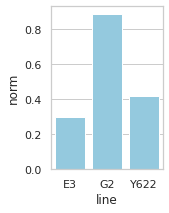

In [566]:
df_temp['binary'] = df_temp['channel_BODIPY']>np.median(df_temp['channel_BODIPY'])#np.percentile(df_temp['channel_BODIPY'], 50)
count_df = df_temp.groupby('line')['binary'].sum().reset_index()
count_df['norm'] = count_df['binary']/np.unique(df_temp['line'], return_counts=True)[1]

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(2, 3))
sns.barplot(x='line', y='norm', data=count_df, color='skyblue')


/state/partition1/slurm_tmp/24493286.0.0/ipykernel_811969/614301983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['binary'] = df_temp['channel_CellRox']>np.median(df_temp['channel_BODIPY'])#np.percentile(df_temp['channel_BODIPY'], 50)


<Axes: xlabel='line', ylabel='norm'>

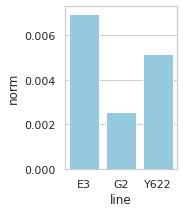

In [567]:
df_temp['binary'] = df_temp['channel_CellRox']>np.median(df_temp['channel_BODIPY'])#np.percentile(df_temp['channel_BODIPY'], 50)
count_df = df_temp.groupby('line')['binary'].sum().reset_index()
count_df['norm'] = count_df['binary']/np.unique(df_temp['line'], return_counts=True)[1]

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(2, 3))
sns.barplot(x='line', y='norm', data=count_df, color='skyblue')


In [553]:
count_df

,line,binary,norm
0,E3,7,0.016166
1,G2,5,0.012853
2,Y622,5,0.006402


<Axes: xlabel='line', ylabel='binary'>

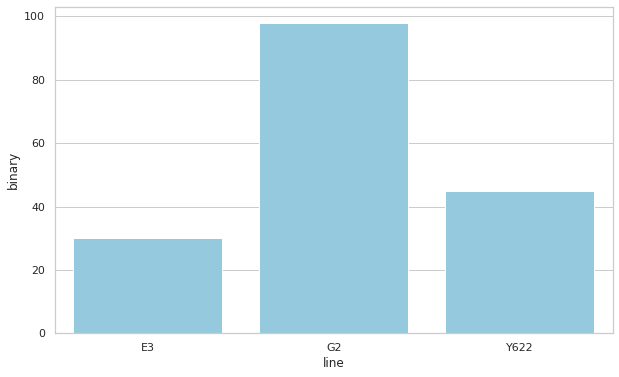

In [514]:
# Count the number of 'True' values in 'binary' per 'line'
count_df = df_temp.groupby('line')['binary'].sum().reset_index()

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='line', y='binary', data=count_df, color='skyblue')


In [515]:
count_df

,line,binary
0,E3,30
1,G2,98
2,Y622,45


In [505]:
df_temp['binary'] = df_temp['channel_BODIPY']>0.05

/state/partition1/slurm_tmp/24493286.0.0/ipykernel_811969/3297432111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['binary'] = df_temp['channel_BODIPY']>0.05


<Axes: xlabel='line', ylabel='channel_BODIPY'>

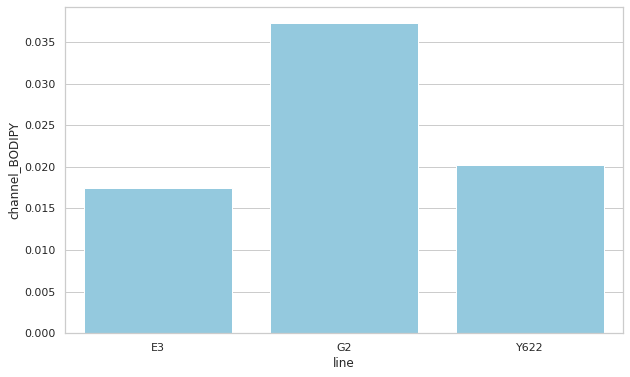

In [511]:
grouped_df = df_temp.groupby('line')['channel_BODIPY'].median().reset_index()

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='line', y='channel_BODIPY', data=grouped_df, color='skyblue')


In [508]:
grouped_df

,line,binary
0,E3,0.069284
1,G2,0.251928
2,Y622,0.057618


In [506]:
df_temp

,channel_DAPI,channel_NeuN,channel_BODIPY,channel_CellRox,ID,file,line,treatment,well,binary
0,0.045105,0.232064,0.010795,0.010466,0,B03-1.czi,E3,vehicle,B03,False
1,0.039051,0.235034,0.010341,0.007472,0,B03-1.czi,E3,vehicle,B03,False
2,0.076149,0.152898,0.013429,0.012434,0,B03-1.czi,E3,vehicle,B03,False
3,0.059883,0.204431,0.010203,0.008750,0,B03-1.czi,E3,vehicle,B03,False
4,0.060988,0.115865,0.009814,0.009259,0,B03-1.czi,E3,vehicle,B03,False
...,...,...,...,...,...,...,...,...,...,...
8703,0.017560,0.145223,0.044533,0.006485,57,G03-1.czi,G2,vehicle,G03,False
8704,0.026192,0.101169,0.026483,0.005685,57,G03-1.czi,G2,vehicle,G03,False
8705,0.012744,0.122345,0.023288,0.006143,57,G03-1.czi,G2,vehicle,G03,False
8706,0.011931,0.125252,0.033199,0.006839,57,G03-1.czi,G2,vehicle,G03,False


In [ ]:
df.groupby('line')['BODIPY_greater_than_x']

In [502]:
# Group by 'cell_line' and calculate the fraction of rows where BODIPY > x
grouped_df = df.groupby('line')['BODIPY_greater_than_x'].mean().reset_index()

# Create a stacked bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='cell_line', y='BODIPY_greater_than_x', data=grouped_df, color='skyblue')


,channel_DAPI,channel_NeuN,channel_BODIPY,channel_CellRox,ID,file,line,treatment,well
0,0.045105,0.232064,0.010795,0.010466,0,B03-1.czi,E3,vehicle,B03
1,0.039051,0.235034,0.010341,0.007472,0,B03-1.czi,E3,vehicle,B03
2,0.076149,0.152898,0.013429,0.012434,0,B03-1.czi,E3,vehicle,B03
3,0.059883,0.204431,0.010203,0.008750,0,B03-1.czi,E3,vehicle,B03
4,0.060988,0.115865,0.009814,0.009259,0,B03-1.czi,E3,vehicle,B03
...,...,...,...,...,...,...,...,...,...
8703,0.017560,0.145223,0.044533,0.006485,57,G03-1.czi,G2,vehicle,G03
8704,0.026192,0.101169,0.026483,0.005685,57,G03-1.czi,G2,vehicle,G03
8705,0.012744,0.122345,0.023288,0.006143,57,G03-1.czi,G2,vehicle,G03
8706,0.011931,0.125252,0.033199,0.006839,57,G03-1.czi,G2,vehicle,G03


In [ ]:
df_temp = df[df['treatment']=='vehicle']

#set1_colors = sns.color_palette('husl')
#colors = dict(zip(np.unique(df['line']), set1_colors[:6]))

colors = dict(zip(np.unique(df['line']), ['grey', 'blue', 'orange']))

sns.set(rc={'figure.figsize':(6,9)})
sns.set_style("whitegrid")

f, ax = plt.subplots(4, sharex=True, gridspec_kw={"height_ratios": (1,.5,1,.5)})


index = df_temp['line']!='G2'
sns.histplot(data=df_temp[index], x='channel_BODIPY', ax=ax[0], hue='line', binwidth=0.002, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_BODIPY', y='line',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)

index = df_temp['line']!='Y622'
sns.histplot(data=df_temp[index], x='channel_BODIPY', ax=ax[2], hue='line', binwidth=0.002, element="step", common_norm=False, stat='density', palette = colors)
sns.boxplot(data=df_temp[index], x='channel_BODIPY', y='line',orient="h", ax=ax[3], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)


plt.xlim(0,0.1)

In [488]:
df_temp

,channel_DAPI,channel_NeuN,channel_BODIPY,channel_CellRox,ID,file,line,treatment
0,0.045105,0.232064,0.010795,0.010466,0,B03-1.czi,E3,vehicle
1,0.039051,0.235034,0.010341,0.007472,0,B03-1.czi,E3,vehicle
2,0.076149,0.152898,0.013429,0.012434,0,B03-1.czi,E3,vehicle
3,0.059883,0.204431,0.010203,0.008750,0,B03-1.czi,E3,vehicle
4,0.060988,0.115865,0.009814,0.009259,0,B03-1.czi,E3,vehicle
...,...,...,...,...,...,...,...,...
8703,0.017560,0.145223,0.044533,0.006485,57,G03-1.czi,G2,vehicle
8704,0.026192,0.101169,0.026483,0.005685,57,G03-1.czi,G2,vehicle
8705,0.012744,0.122345,0.023288,0.006143,57,G03-1.czi,G2,vehicle
8706,0.011931,0.125252,0.033199,0.006839,57,G03-1.czi,G2,vehicle


In [480]:
colors

{'E3': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'G2': (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 'Y622': (0.3126890019504329, 0.6928754610296064, 0.1923704830330379)}

(0.0, 0.1)

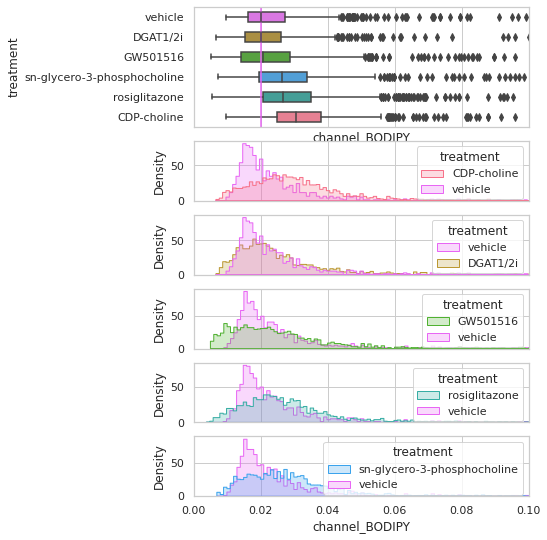

In [454]:
plot_all_effects(df, 'Y622', 'channel_BODIPY', 'density', colors)
plt.xlim(0,0.1)

In [271]:
df.index = range(df.shape[0])

In [438]:
temp = df[np.array(df['treatment']=='vehicle')]


(0.0, 0.03)

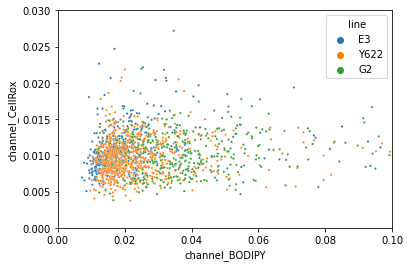

In [441]:
sns.scatterplot(data=temp, x='channel_BODIPY', y='channel_CellRox', s=5, hue='line')
plt.xlim(0,0.1)
plt.ylim(0,0.03)

(0.0, 0.03)

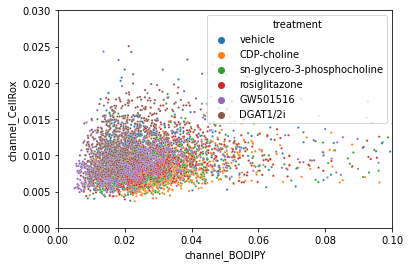

In [446]:
sns.scatterplot(data=df[df['line']=='Y622'], x='channel_BODIPY', y='channel_CellRox', s=5, hue='treatment')
plt.xlim(0,0.1)
plt.ylim(0,0.03)

(0.0, 0.03)

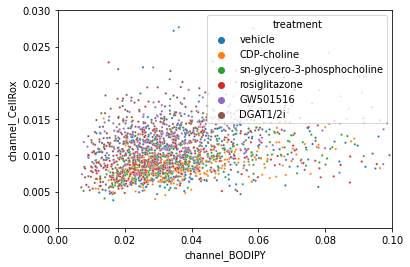

In [447]:
sns.scatterplot(data=df[df['line']=='G2'], x='channel_BODIPY', y='channel_CellRox', s=5, hue='treatment')
plt.xlim(0,0.1)
plt.ylim(0,0.03)

(0.0, 0.03)

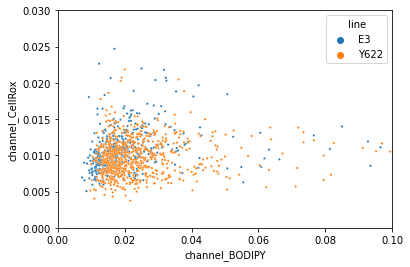

In [440]:
sns.scatterplot(data=temp[temp['line']!='G2'], x='channel_BODIPY', y='channel_CellRox', s=5, hue='line')
plt.xlim(0,0.1)
plt.ylim(0,0.03)

In [386]:
temp = df[np.array(df['treatment']=='vehicle')]
temp = temp[temp['channel_BODIPY']<np.median(temp['channel_BODIPY'])]

In [387]:
temp.shape

(801, 8)

(0.0, 0.02)

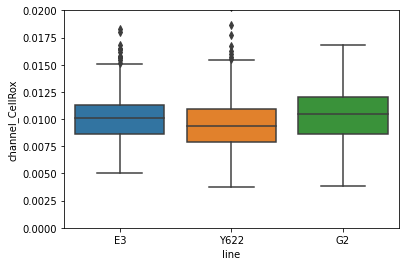

In [388]:
sns.boxplot(data = temp, x='line', y='channel_CellRox')
plt.ylim(0,0.02)

(0.0, 0.02)

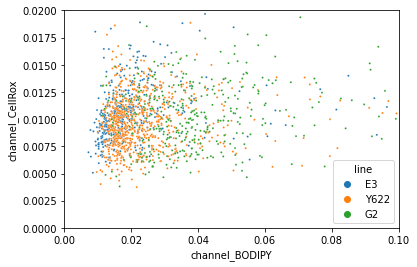

In [401]:
sns.scatterplot(data=temp, x='channel_BODIPY', y='channel_CellRox', s=4, hue='line')
plt.xlim(0,0.1)
plt.ylim(0,0.02)

(0.0, 0.03)

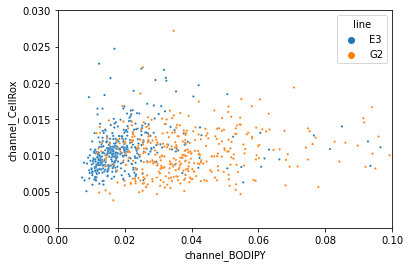

In [411]:
sns.scatterplot(data=temp[temp['line']!='Y622'], x='channel_BODIPY', y='channel_CellRox', s=5, hue='line')
plt.xlim(0,0.1)
plt.ylim(0,0.03)

(0.0, 0.03)

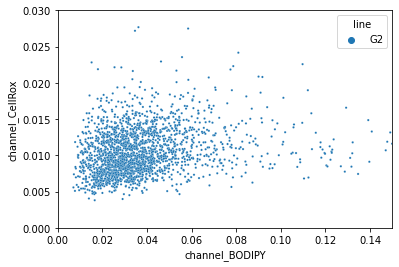

In [416]:
sns.scatterplot(data=df[df['line']=='G2'], x='channel_BODIPY', y='channel_CellRox', s=5, hue='line')
plt.xlim(0,0.15)
plt.ylim(0,0.03)

(0.0, 0.03)

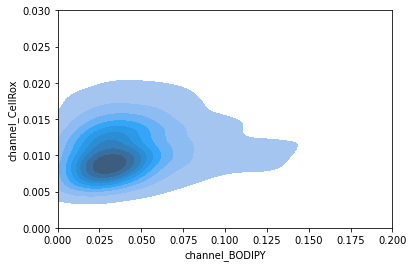

In [437]:
sns.kdeplot(data=df[df['line']=='G2'], x='channel_BODIPY', y='channel_CellRox', fill=True)
plt.xlim(0,0.2)
plt.ylim(0,0.03)

(0.0, 0.1)

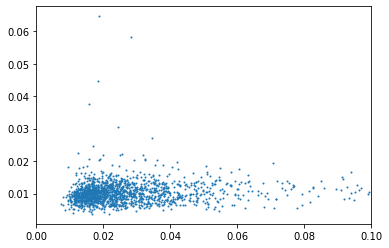

In [391]:
temp = df[np.array(df['treatment']=='vehicle')]

plt.scatter(temp['channel_BODIPY'], temp['channel_CellRox'], s=1)
plt.xlim(0,0.1)

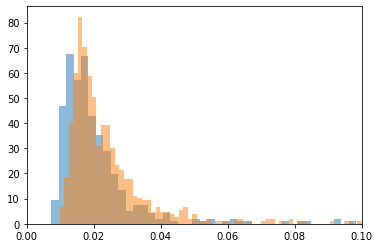

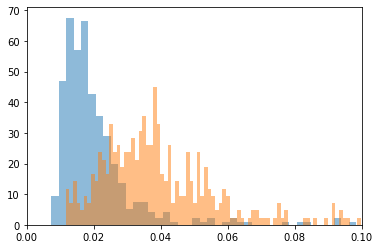

In [309]:
cellline = ['E3', 'Y622']
for i in cellline:
    temp = df[np.array(df['treatment']=='vehicle') & np.array(df['line']==i)]
    plt.hist(temp['channel_BODIPY'],400, density=True, alpha=0.5)
    #plt.xscale('log')
    plt.xlim(0,0.1)
    None
    
plt.figure()
cellline = ['E3', 'G2']
for i in cellline:
    temp = df[np.array(df['treatment']=='vehicle') & np.array(df['line']==i)]
    plt.hist(temp['channel_BODIPY'],400, density=True, alpha=0.5)
    #plt.xscale('log')
    plt.xlim(0,0.1)
    None

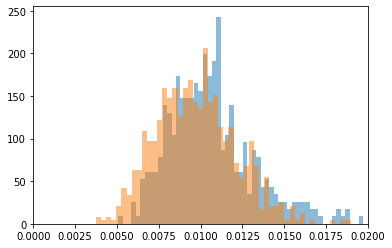

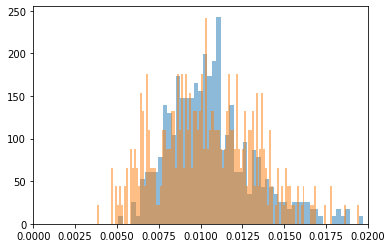

In [360]:
cellline = ['E3', 'Y622']
for i in cellline:
    temp = df[np.array(df['treatment']=='vehicle') & np.array(df['line']==i)]
    plt.hist(temp['channel_CellRox'],200, density=True, alpha=0.5)
    #plt.xscale('log')
    plt.xlim(0,0.02)
    None
    
plt.figure()
cellline = ['E3', 'G2']
for i in cellline:
    temp = df[np.array(df['treatment']=='vehicle') & np.array(df['line']==i)]
    plt.hist(temp['channel_CellRox'],200, density=True, alpha=0.5)
    #plt.xscale('log')
    plt.xlim(0,0.02)
    None

(0.0, 0.1)

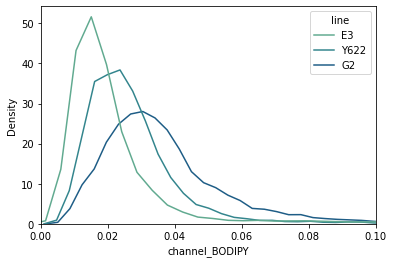

In [351]:
sns.kdeplot(data=df, x='channel_BODIPY',hue='line',common_norm=False,bw_adjust=0.2, palette="crest")
plt.xlim(0,0.1)
#plt.xscale('log')

(0.0, 0.05)

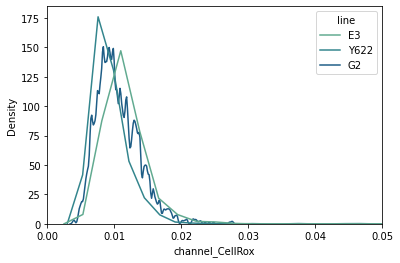

In [357]:
sns.kdeplot(data=df, x='channel_CellRox',hue='line',common_norm=False,bw_adjust=0.2, palette="crest")
plt.xlim(0,0.05)
#plt.xscale('log')

<Axes: xlabel='channel_NeuN', ylabel='Density'>

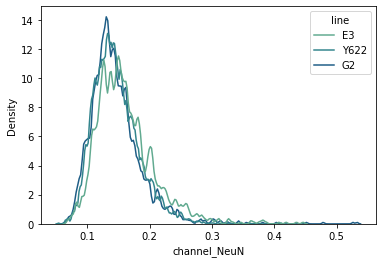

In [353]:
sns.kdeplot(data=df, x='channel_NeuN',hue='line',common_norm=False,bw_adjust=0.2, palette="crest")
#plt.xlim(0,0.1)
#plt.xscale('log')

In [ ]:
def plot_all_effects(data, cellline, x, stat, colors, bw=0.001):
    sns.set(rc={'figure.figsize':(6,9)})
    sns.set_style("whitegrid")
    index_all = data['line']==cellline

    treatments = np.unique(data[index_all]['treatment'])
    f, ax = plt.subplots(len(treatments), sharex=True, gridspec_kw={"height_ratios": (1,.5,.5,.5,.5,.5)})
    
    treatment = np.unique(data[index_all]['treatment'])
    
    treatment = treatment[[x not in 'vehicle' for x in treatment]]

    names = (data[index_all].groupby('treatment')[x].median())
    order = names.index[np.argsort(names)]

    sns.boxplot(data=data[index_all], x=x, y='treatment',orient="h", ax=ax[0], width=.5, dodge=True, order =(order), palette = colors)
    ax[0].axvline(x=names['vehicle'], color = colors['vehicle'])
        
    for i in range(len(ax)-1):
        index = (data['line'] == cellline) & (data['treatment']=='vehicle') | (data['treatment']==treatment[i])
        sns.histplot(data=data[index], x=x, ax=ax[i+1], hue='treatment', binwidth=bw, palette=colors, element="step", common_norm=False, stat=stat)
    


<Axes: xlabel='treatment', ylabel='channel_NeuN'>

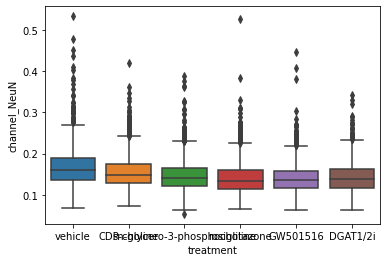

In [243]:
sns.boxplot(data=df, x = 'treatment', y = 'channel_NeuN')

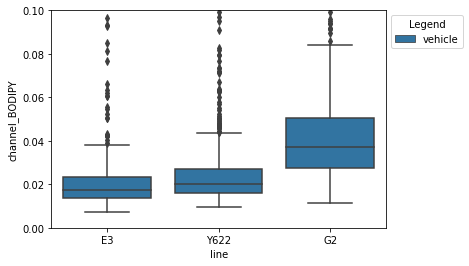

In [254]:
sns.boxplot(data=df[df['treatment']=='vehicle'], x = 'line', y = 'channel_BODIPY', hue='treatment')
plt.ylim(0,0.1)
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))


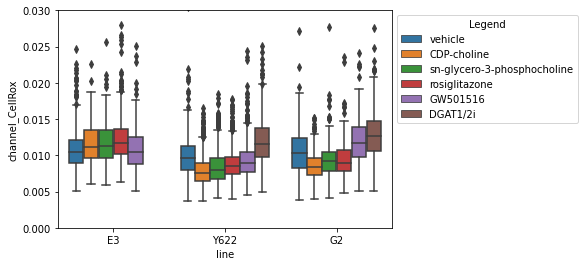

In [251]:
sns.boxplot(data=df, x = 'line', y = 'channel_CellRox', hue='treatment')
plt.ylim(0,0.03)
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))


(0.0, 0.05)

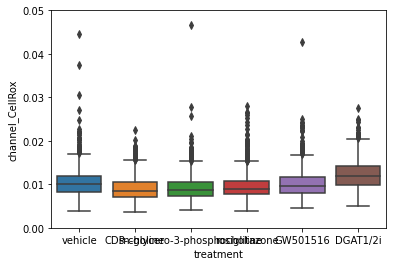

In [245]:
sns.boxplot(data=df, x = 'treatment', y = 'channel_CellRox')
plt.ylim(0,0.05)

(0.0, 0.04)

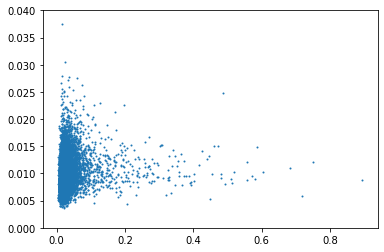

In [236]:
plt.scatter(df['channel_BODIPY'], df['channel_CellRox'], s=1)
plt.ylim(0,0.04)


In [225]:
df

,channel_DAPI,channel_NeuN,channel_BODIPY,channel_CellRox,ID,file,line,treatment
0,0.045105,0.232064,0.010795,0.010466,0,B03-1.czi,E3,vehicle
1,0.039051,0.235034,0.010341,0.007472,0,B03-1.czi,E3,vehicle
2,0.076149,0.152898,0.013429,0.012434,0,B03-1.czi,E3,vehicle
3,0.059883,0.204431,0.010203,0.008750,0,B03-1.czi,E3,vehicle
4,0.060988,0.115865,0.009814,0.009259,0,B03-1.czi,E3,vehicle
...,...,...,...,...,...,...,...,...
51,0.031230,0.111483,0.022716,0.009353,67,G11-2.czi,G2,DGAT1/2i
52,0.063719,0.094781,0.053650,0.005076,67,G11-2.czi,G2,DGAT1/2i
53,0.038615,0.125504,0.016576,0.007658,67,G11-2.czi,G2,DGAT1/2i
54,0.041142,0.120191,0.009168,0.007124,67,G11-2.czi,G2,DGAT1/2i


In [197]:
probs_sele = probs[start:end].ravel()
masks_sele = masks[start:end].ravel()
out_float_sele = out_float[start:end]

In [206]:
outputs[1:].shape

(152, 4)

(array([146.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00979409, 0.0465123 , 0.0832305 , 0.1199487 , 0.15666691,
        0.19338511, 0.23010331, 0.26682152, 0.30353972, 0.34025792,
        0.37697613]),
 <BarContainer object of 10 artists>)

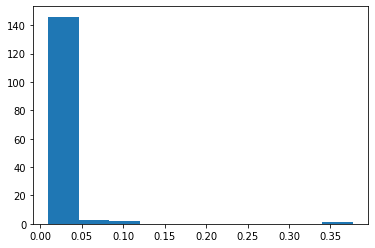

In [211]:
plt.hist(df['channel_BODIPY'])

(array([146.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00981391, 0.04771696, 0.08562002, 0.12352307, 0.16142613,
        0.19932918, 0.23723224, 0.27513529, 0.31303835, 0.35094141,
        0.38884446]),
 <BarContainer object of 10 artists>)

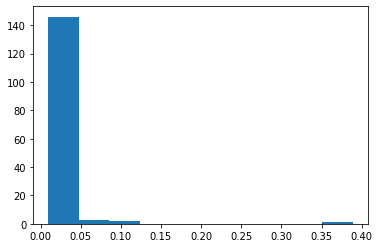

In [208]:
plt.hist(df['channel_BODIPY'])

In [192]:
df

,channel_0,channel_1,channel_2,channel_3
0,0.062262,0.087772,0.024740,0.012882
1,0.045105,0.232064,0.010795,0.010466
2,0.039051,0.235034,0.010341,0.007472
3,0.076149,0.152898,0.013429,0.012434
4,0.059883,0.204431,0.010203,0.008750
...,...,...,...,...
148,0.040009,0.151225,0.028743,0.016890
149,0.071660,0.180768,0.025040,0.021979
150,0.081922,0.159018,0.041022,0.016433
151,0.066671,0.167003,0.021448,0.015191


(array([14., 25., 33., 43., 19.,  6.,  6.,  2.,  2.,  3.]),
 array([0.00551769, 0.00716386, 0.00881003, 0.0104562 , 0.01210237,
        0.01374854, 0.01539471, 0.01704088, 0.01868704, 0.02033321,
        0.02197938]),
 <BarContainer object of 10 artists>)

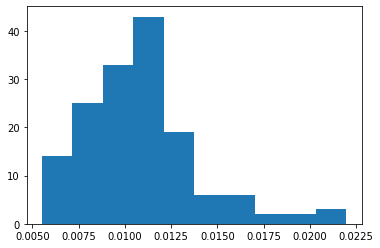

In [189]:
plt.hist(outputs[:,3])

(array([12., 36., 45., 27., 13.,  9.,  6.,  3.,  0.,  2.]),
 array([0.06617991, 0.09775722, 0.12933453, 0.16091184, 0.19248914,
        0.22406645, 0.25564376, 0.28722106, 0.31879837, 0.35037568,
        0.38195298]),
 <BarContainer object of 10 artists>)

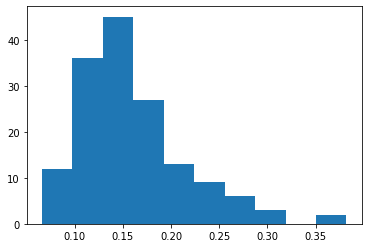

In [157]:
import numba as nb
@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E_uniform, E_nonuniform):
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        E_uniform[M] = np.mean(temp_vals)
        E_nonuniform[M] = np.dot(temp_vals, temp_probs/np.sum(temp_probs))

0.22548839567531867

0.23206430049519297

(array([  25.,   29.,   31.,   35.,   33.,   26.,   42.,   44.,   74.,
        1551.]),
 array([0.00026855, 0.00029721, 0.00032588, 0.00035454, 0.00038321,
        0.00041187, 0.00044054, 0.0004692 , 0.00049787, 0.00052653,
        0.00055519]),
 <BarContainer object of 10 artists>)

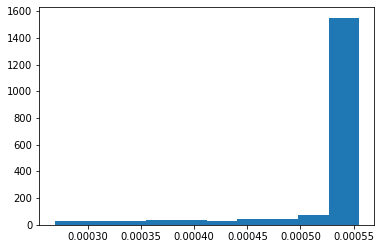

In [131]:
plt.hist(temp_probs/np.sum(temp_probs))

In [127]:
1/len(temp_probs)

0.0005291005291005291

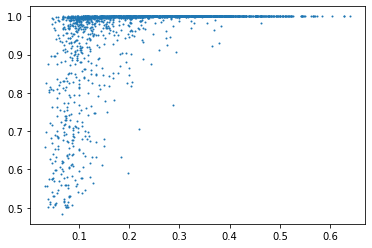

In [120]:
plt.scatter(temp_vals, temp_probs, s=1)

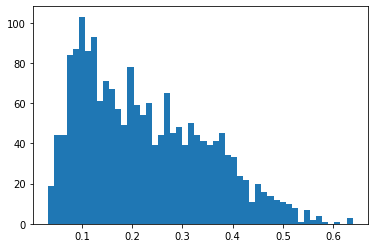

In [107]:
plt.hist(temp_vals, 50)
None

In [88]:
probs_sele.shape

(19, 1024, 1024)

In [85]:
vals_sele.shape

(19, 1024, 1024, 4)

In [72]:
np.array_equal(out_float, temp)

True

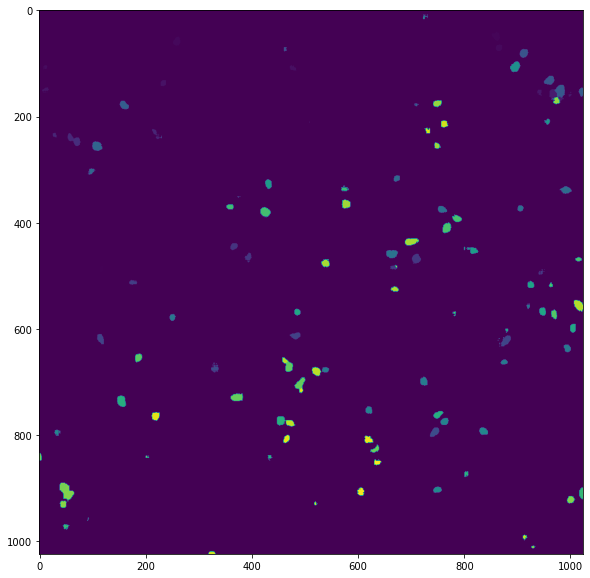

In [70]:
plt.figure(figsize=(10,10))

plt.imshow(masks[8])

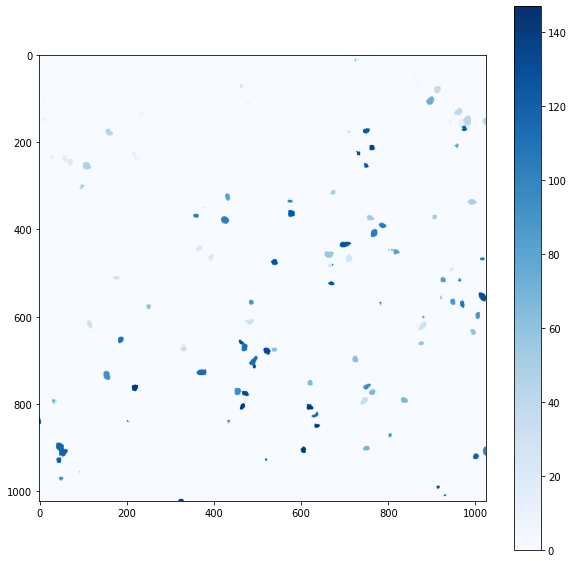

In [81]:
plt.figure(figsize=(10,10))

plt.imshow(masks_sele[8], cmap='Blues')
plt.colorbar()

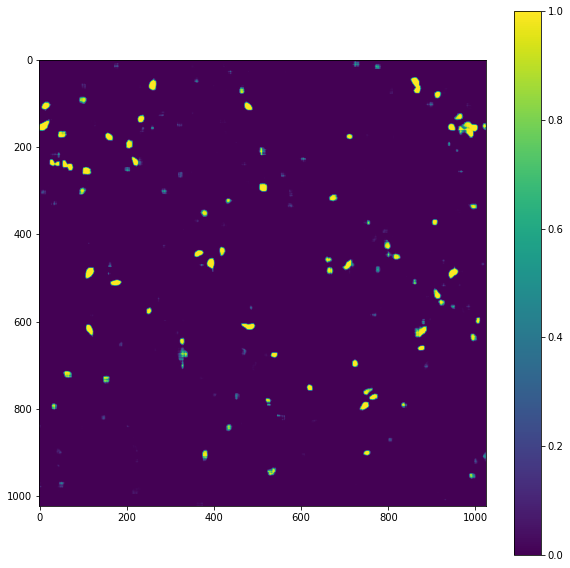

In [84]:
plt.figure(figsize=(10,10))

plt.imshow(probs_sele[4])
plt.colorbar()

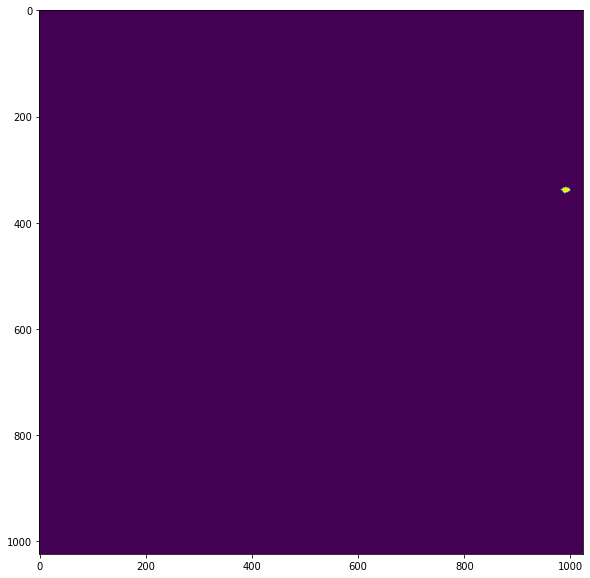

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(masks[10]==35)

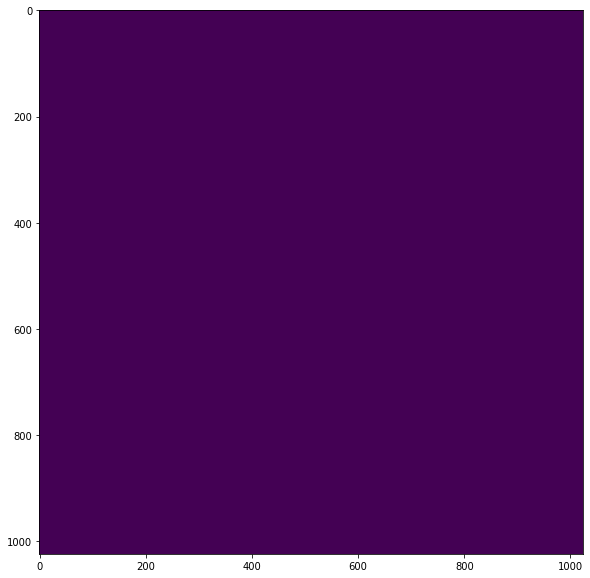

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(masks[]==35)

In [16]:
np.sum(masks[10]==10)

0

In [17]:
np.unique(masks[10])

array([  0,  11,  16,  22,  23,  24,  25,  35,  36,  38,  39,  48,  52,
        54,  59,  61,  65,  69,  74,  75,  76,  77,  80,  82,  83,  84,
        85,  86,  90,  92,  93,  94,  95,  96,  97,  98,  99, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123], dtype=uint16)

In [ ]:
# does per image quantification match what is visibly true?

sele = np.argwhere(np.array([i=='vehicle' for i in treat]) & np.array([i=='G2' for i in lines])).reshape(-1)

all_res = []
channels = [1,2,3]
for n,i in (enumerate(sele)):
    img = AICSImage('./data/neuronbatch11082023_cellrox_bodipy/'+files[i])
    out = load_3D(img, [0,2,1,3])
    out_float = int_to_float(out)
    res = []
    
    for s in tqdm(range(out_float.shape[0])):
        
        masks, flows, styles, _ = model.eval(out_float[s], diameter=15, channels=[2,0], do_3D=False, normalize = False)
        
        temp3 = flows[2]
        x2 = np.unique(masks)
        f3 = [np.mean(sigmoid(temp3[masks==g])) for g in x2]
        d = pd.DataFrame(f3)
        d.columns = ['prob']
        d['ID'] = i
        d['cellline'] = 'G2'
        d['Zi'] = s
        
        for x in channels:
            temp2 = out_float[s][:,:,x]
            f2 = [np.mean(temp2[masks==g]) for g in x2]
            d['channel_' + str(x)] = f2

        res.append(d)
    all_res.append(pd.concat(res))